<a href="https://colab.research.google.com/github/Hitika-Jain/ParkInsight/blob/main/improvedlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

In [3]:
!pip install librosa soundfile numpy pandas tensorflow tqdm

In [16]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# def extract_mfcc(file_path, max_pad_len=100):
#     try:
#         y, sr = librosa.load(file_path, sr=22050)  # Load audio
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs

#         # Pad or truncate to a fixed length
#         if mfcc.shape[1] < max_pad_len:
#             pad_width = max_pad_len - mfcc.shape[1]
#             mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
#         else:
#             mfcc = mfcc[:, :max_pad_len]

#         return mfcc.T  # Shape: (timesteps, features)
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return None

In [17]:
import os
import librosa
import numpy as np
from tqdm import tqdm

data = []
labels = []

# Define the dataset path
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

# Define category paths and labels
categories = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

# Function to extract MFCC features
def extract_mfcc(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCCs
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # 12 chroma
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # 7 spectral contrast
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)  # 6 tonnetz

        # Stack vertically
        features = np.vstack([mfcc, chroma, spec_contrast, tonnetz])  # shape (65, time_steps)

        # Pad or truncate
        if features.shape[1] < max_pad_len:
            pad_width = max_pad_len - features.shape[1]
            features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            features = features[:, :max_pad_len]

        return features.T  # (time_steps, features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process each category
for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip files like "FILE CODES.xlsx"

    if category == "28 People with Parkinson's disease":  # Handling nested structure
        for group_folder in tqdm(os.listdir(category_path), desc="Processing Parkinson's patients"):
            group_path = os.path.join(category_path, group_folder)

            if not os.path.isdir(group_path):
                continue  # Skip any non-directory files

            for patient_folder in os.listdir(group_path):
                patient_path = os.path.join(group_path, patient_folder)

                if not os.path.isdir(patient_path):
                    continue  # Skip any non-directory files

                for file in os.listdir(patient_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(patient_path, file)
                        mfcc_features = extract_mfcc(file_path)

                        if mfcc_features is not None:
                            data.append(mfcc_features)
                            labels.append(label)

    else:  # Normal structure (Healthy Controls)
        for patient_folder in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            patient_path = os.path.join(category_path, patient_folder)

            if not os.path.isdir(patient_path):
                continue  # Skip any non-directory files

            for file in os.listdir(patient_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(patient_path, file)
                    mfcc_features = extract_mfcc(file_path)

                    if mfcc_features is not None:
                        data.append(mfcc_features)
                        labels.append(label)

# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

print(f"Extracted {X.shape[0]} samples with shape {X.shape[1:]}")  # (samples, timesteps, features)

Processing Parkinson's patients: 100%|██████████| 6/6 [16:45<00:00, 167.53s/it]

Extracted 831 samples with shape (100, 65)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape
print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

Training samples: (664, 100, 65), Testing samples: (167, 100, 65)


In [7]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(100, 65)),  # 100 timesteps, 13 features
    Dropout(0.3),
    LSTM(32, return_sequences=False),  # 100 timesteps, 13 features
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())  # Print model structure

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,729 (178.63 KB)

 Trainable params: 45,729 (178.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Look at validation loss
    factor=0.5,              # Reduce learning rate by a factor of 0.5
    patience=5,              # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,             # Lower bound on the learning rate
    verbose=1                # Print update messages
)

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6372 - loss: 0.6510 - val_accuracy: 0.8503 - val_loss: 0.4099
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8645 - loss: 0.3429 - val_accuracy: 0.7006 - val_loss: 0.5984
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9048 - loss: 0.2829 - val_accuracy: 0.8563 - val_loss: 0.4192
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8328 - loss: 0.4078 - val_accuracy: 0.9162 - val_loss: 0.2693
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9431 - loss: 0.1769 - val_accuracy: 0.9222 - val_loss: 0.2317
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9744 - loss: 0.1017 - val_accuracy: 0.9281 - val_loss: 0.2422
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9692 - loss: 0.0903 - val_accuracy: 0.8683 - val_loss: 0.4072
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9261 - loss: 0.1523 - val_accuracy: 0.

In [10]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5877 - loss: 0.6579 - val_accuracy: 0.8503 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8908 - loss: 0.3498 - val_accuracy: 0.8683 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9078 - loss: 0.2763 - val_accuracy: 0.9162 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9401 - loss: 0.1737 - val_accuracy: 0.9521 - val_loss: 0.1543 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9071 - loss: 0.2322 - val_accuracy: 0.9401 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9251 - loss: 0.2411 - val_accuracy: 0.9341 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9541 - loss: 0.1403 - 

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9446 - loss: 0.1778
Test Accuracy: 0.9521


In [12]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Confusion Matrix:
[[76  3]
 [ 5 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        79
           1       0.97      0.94      0.95        88

    accuracy                           0.95       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.95      0.95      0.95       167



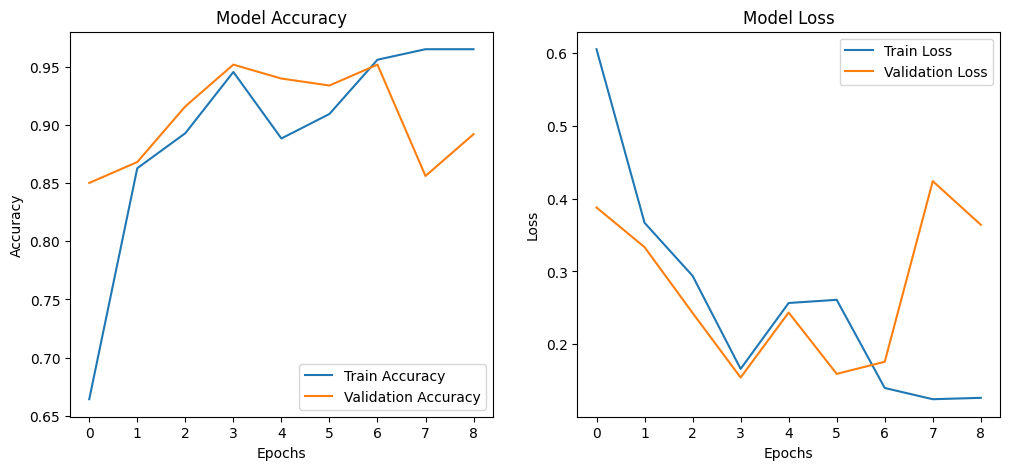

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

#bidirectional lstm

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

# Attention Layer
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Build Model
input_layer = Input(shape=(100, 65))

x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.2)(x)

x = Attention()(x)  # Apply Attention after second BiLSTM

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 65)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,005 (421.89 KB)

 Trainable params: 108,005 (421.89 KB)

 Non-trainable params: 0 (0.00 B)

None



--- Fold 1 ---
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.7233 - loss: 0.5752 - val_accuracy: 0.9102 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.9321 - loss: 0.1843 - val_accuracy: 0.9401 - val_loss: 0.1787 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9758 - loss: 0.0902 - val_accuracy: 0.9162 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9653 - loss: 0.0808 - val_accuracy: 0.9760 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9852 - loss: 0.0519 - val_accuracy: 0.9222 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9769 - loss: 0.0584 - val_accuracy: 0.9521 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accu

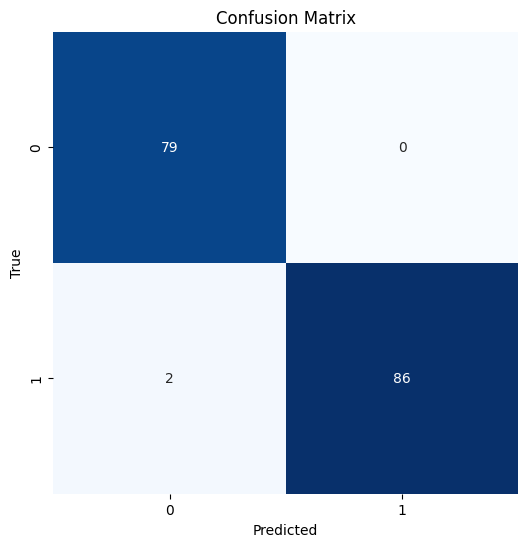


Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        79
           1       1.00      0.98      0.99        88

    accuracy                           0.99       167
   macro avg       0.99      0.99      0.99       167
weighted avg       0.99      0.99      0.99       167



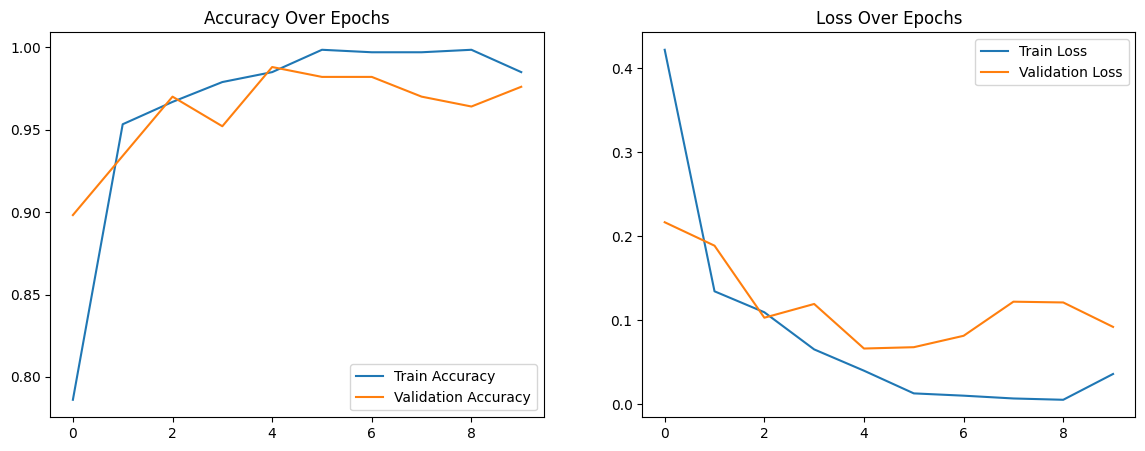

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------ ATTENTION LAYER ------------------------
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# ------------------------ MODEL FUNCTION ------------------------
def create_model(input_shape=(100, 65)):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Attention()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ------------------------ TRAINING WITH STRATIFIED K-FOLD ------------------------

# Assume X and y are your features and labels
# X.shape = (samples, 100, 65)
# y.shape = (samples, )

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []
histories = []

for train_idx, val_idx in kfold.split(X, y):
    print(f'\n--- Fold {fold_no} ---')

    model = create_model()

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        X[train_idx], y[train_idx],
        epochs=100,
        batch_size=8,
        validation_data=(X[val_idx], y[val_idx]),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    scores = model.evaluate(X[val_idx], y[val_idx], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]} ; {model.metrics_names[1]} = {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    histories.append(history)

    fold_no += 1

# ------------------------ FINAL TRAINING ON FULL DATA ------------------------

# Now train once fully on full data
final_model = create_model()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ------------------------ TESTING ------------------------

y_pred = (final_model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------ PLOTS ------------------------

# Accuracy and Loss plots
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.show()

plot_history(history)

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0030
Test Accuracy: 1.0000


final

In [18]:
X_train = X
y_train = y
print(f"Training samples: {X_train.shape}")

Training samples: (831, 100, 65)



--- Fold 1 ---
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.6131 - loss: 0.6848 - val_accuracy: 0.7964 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8844 - loss: 0.3316 - val_accuracy: 0.8802 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9565 - loss: 0.1744 - val_accuracy: 0.9281 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9735 - loss: 0.1195 - val_accuracy: 0.9641 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9899 - loss: 0.0855 - val_accuracy: 0.9521 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9866 - loss: 0.0817 - val_accuracy: 0.9461 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.6211 - loss: 0.6624 - val_accuracy: 0.7500 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9320 - loss: 0.2477
Epoch 2: val_loss improved from 0.62186 to 0.47576, saving model to /content/drive/MyDrive/final_audio_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9320 - loss: 0.2472 - val_accuracy: 0.8571 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9703 - loss: 0.1164
Epoch 3: val_loss improved from 0.47576 to 0.40584, saving model to /content/drive/MyDrive/final_audio_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9704 - loss: 0.1164 - val_accuracy: 0.8929 - val_loss: 0.4058 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9970 - loss: 0.0479
Epoch 4: val_loss did not improve from 0.40584
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.9969 - loss: 0.0480 - val_accuracy: 0.8929 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9977 - loss: 0.0380
Epoch 5: val_loss did not improve from 0.40584
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9976 - loss: 0.0380 - val_accuracy: 0.8810 - val_loss: 0.4348 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9977 - loss: 0.0329
Epoch 6: val_loss did not improve from 0.40584
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9976 - loss: 0.0330 - val_accuracy: 0.8929 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━

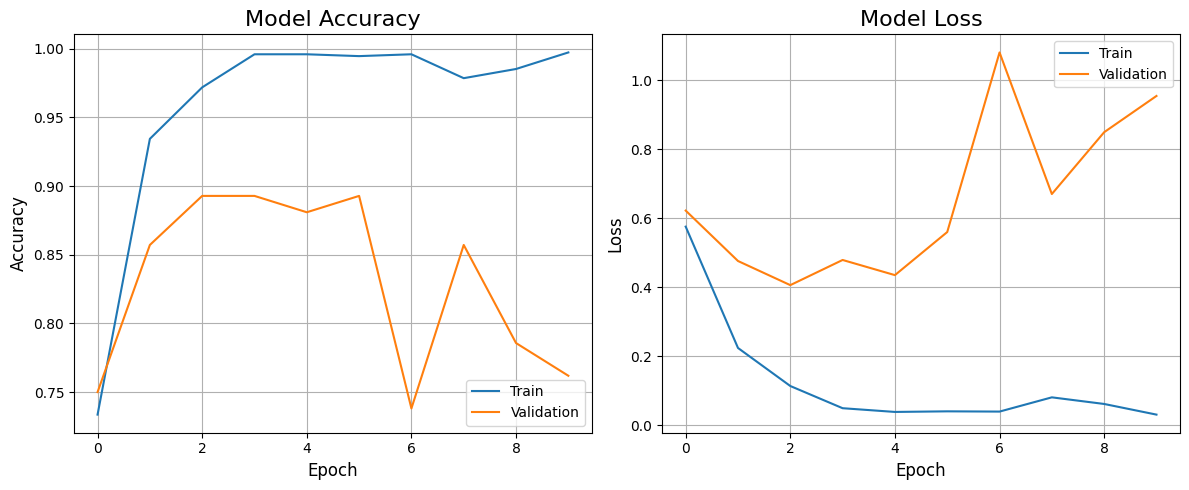

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------ SET SEEDS ------------------------
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# ------------------------ ATTENTION LAYER ------------------------
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],),  # corrected shape
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b[:, tf.newaxis])
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# ------------------------ MODEL FUNCTION ------------------------
def create_model(input_shape=(100, 65)):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4)))(inputs)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ------------------------ TRAINING WITH STRATIFIED K-FOLD ------------------------

# Assuming you already have X, y loaded
# X.shape = (samples, 100, 65)
# y.shape = (samples, )

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []
histories = []

for train_idx, val_idx in kfold.split(X, y):
    print(f'\n--- Fold {fold_no} ---')

    model = create_model()

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        X[train_idx], y[train_idx],
        epochs=100,
        batch_size=16,
        validation_data=(X[val_idx], y[val_idx]),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    scores = model.evaluate(X[val_idx], y[val_idx], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]} ; {model.metrics_names[1]} = {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    histories.append(history)

    fold_no += 1

# ------------------------ FINAL TRAINING ON FULL DATA ------------------------

checkpoint = ModelCheckpoint('/content/drive/MyDrive/final_audio_model.h5',
                              monitor='val_loss', save_best_only=True, verbose=1)

final_model = create_model()

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = final_model.fit(
    X, y,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ------------------------ PLOT TRAINING ------------------------

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.6887 - loss: 0.5570 - val_accuracy: 0.5595 - val_loss: 1.2315 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9320 - loss: 0.1700 - val_accuracy: 0.7619 - val_loss: 0.6083 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9651 - loss: 0.0937 - val_accuracy: 0.7381 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9806 - loss: 0.0559 - val_accuracy: 0.7857 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9821 - loss: 0.0436 - val_accuracy: 0.8690 - val_loss: 0.3745 - learning_rate: 0.0010
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.9743 - loss: 0.0588 - val_accuracy: 0.7738 - val_loss: 0.7321 - learning_rate: 0.0010
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9976 - l

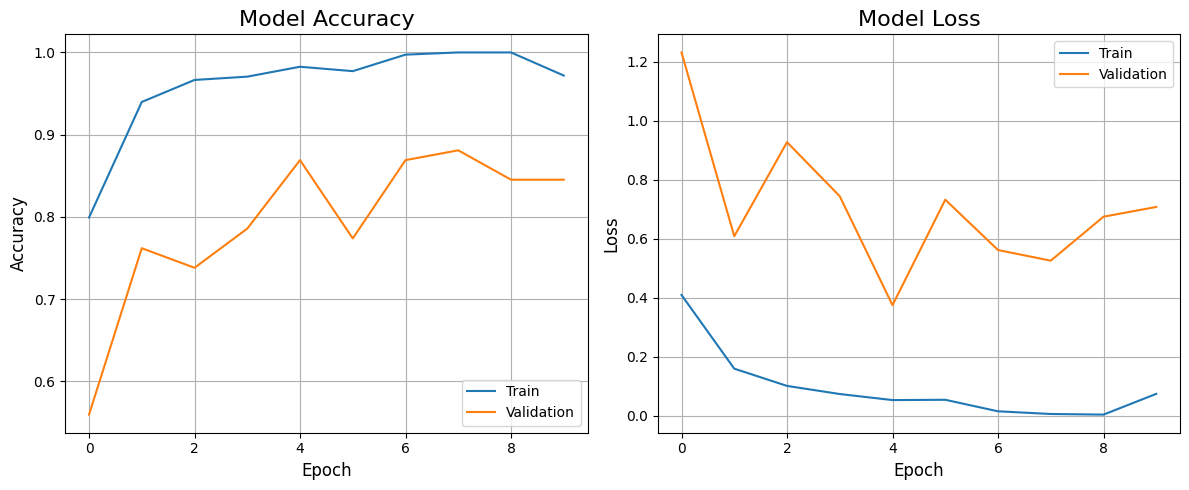

In [2]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# ===== Feature extraction function =====
def extract_mfcc(file_path, n_mfcc=40, max_len=100):
    max_pad_len = max_len
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # 40 MFCCs
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # 12 chroma
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # 7 spectral contrast
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)  # 6 tonnetz

        # Stack vertically
        features = np.vstack([mfcc, chroma, spec_contrast, tonnetz])  # shape (65, time_steps)

        # Pad or truncate
        if features.shape[1] < max_pad_len:
            pad_width = max_pad_len - features.shape[1]
            features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            features = features[:, :max_pad_len]

        return features.T  # (time_steps, features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ===== Paths =====
unknown_data_path = '/content/drive/MyDrive/audio test'  # change this
hc_path = os.path.join(unknown_data_path, 'HC_AH')
pd_path = os.path.join(unknown_data_path, 'PD_AH')

# ===== Collect files and labels =====
unknown_files = []
unknown_labels = []

# HC files (label 0)
for file in os.listdir(hc_path):
    if file.endswith('.wav'):
        unknown_files.append(os.path.join(hc_path, file))
        unknown_labels.append(0)

# PD files (label 1)
for file in os.listdir(pd_path):
    if file.endswith('.wav'):
        unknown_files.append(os.path.join(pd_path, file))
        unknown_labels.append(1)

# ===== Extract features =====
X_unknown = np.array([extract_mfcc(file) for file in unknown_files])

# Convert labels to numpy array
y_true = np.array(unknown_labels)

print(f"Unknown dataset shape: {X_unknown.shape}")
print(f"True labels shape: {y_true.shape}")

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=803
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=560
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=567
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=618
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=979
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=939
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: 

Unknown dataset shape: (81, 100, 65)
True labels shape: (81,)


In [3]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load real-world data (update paths if needed)
#X_real = np.load("X_real.npy")  # shape: (n_samples, 64, 64, 64, 1)
# y_real = np.load("y_real.npy")  # shape: (n_samples, )

# Split real-world data: 80% fine-tuning, 20% final test
X_train, X_test, y_train, y_test = train_test_split(
    X_unknown, y_true, test_size=0.2, stratify=y_true, random_state=42
)

# Load trained model
model = load_model("/content/drive/MyDrive/lstmf_model.h5")

# Optional: Unfreeze layers if model was partially frozen
# for layer in model.layers:
#     layer.trainable = True

# Compile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune on real-world data
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.4,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop]
)

# Evaluate on real-world holdout
loss, acc = model.evaluate(X_test, y_test)
print(f"Fine-tuned Accuracy on Real Data: {acc:.4f}")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.5522 - loss: 1.5970 - val_accuracy: 0.4615 - val_loss: 1.6563
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6020 - loss: 1.5199 - val_accuracy: 0.4615 - val_loss: 1.6559
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5288 - loss: 1.4648 - val_accuracy: 0.4615 - val_loss: 1.6554
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5263 - loss: 1.4882 - val_accuracy: 0.4615 - val_loss: 1.6550
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4897 - loss: 1.4986 - val_accuracy: 0.4615 - val_loss: 1.6547
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5757 - loss: 1.3672 - val_accuracy: 0.4615 - val_loss: 1.6544
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5288 - loss: 1.6457 - val_accuracy: 0.4615 - val_loss: 1.6540
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4922 - loss: 1.7216 - val_accuracy: 0.4615 - val_loss

In [5]:
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([32, 32]))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

Results:
AH_473R_E4947FD3-23C1-44F1-BCE4-DC59D8269FDE.wav --> True: 0 | Predicted: 1
AH_420J_07C96C2C-6E96-4A2F-BEC9-5CB71DB309B6.wav --> True: 0 | Predicted: 0
AH_678A_2E7AFA48-34C1-4DAD-A73C-95F7ABF6B138.wav --> True: 0 | Predicted: 1
AH_264Z_593C20CD-0A54-4177-B031-26EE147080A3.wav --> True: 0 | Predicted: 1
AH_444B_E1586F09-1BF5-408D-A55E-96D9E8B76A43.wav --> True: 0 | Predicted: 1
AH_777G_4C8ACC89-7FE2-4174-AE3A-B21B39A0C869.wav --> True: 0 | Predicted: 1
AH_333L_6C551A6E-CC47-410E-AA49-2DC0A86E6489.wav --> True: 0 | Predicted: 0
AH_789Y_20CB672C-5F66-425E-8707-BE5B7FF807E2.wav --> True: 0 | Predicted: 0
AH_469Z_5BB05B2C-39C4-434D-9445-244E7580F840.wav --> True: 0 | Predicted: 1
AH_753G_073DCC32-4397-4719-A019-DDD41F30F5F1.wav --> True: 0 | Predicted: 0
AH_888A_7F1444B0-B12C-4B55-AF2A-463395DCAF3C.wav --> True: 0 | Predicted: 0
AH_528T_6A746E6E-FB60-4363-842F-A7368A1E5B2C.wav --> True: 0 | Predicted: 1
AH_667J_605FB4D5-E0DB-4B9B-8F58-784561C

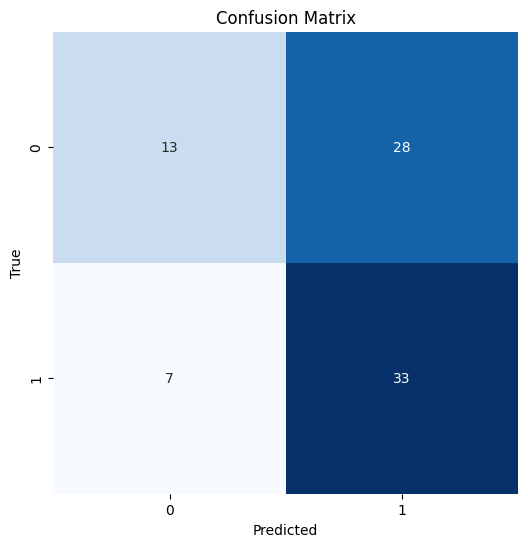


Accuracy: 0.5679012345679012

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.32      0.43        41
           1       0.54      0.82      0.65        40

    accuracy                           0.57        81
   macro avg       0.60      0.57      0.54        81
weighted avg       0.60      0.57      0.54        81



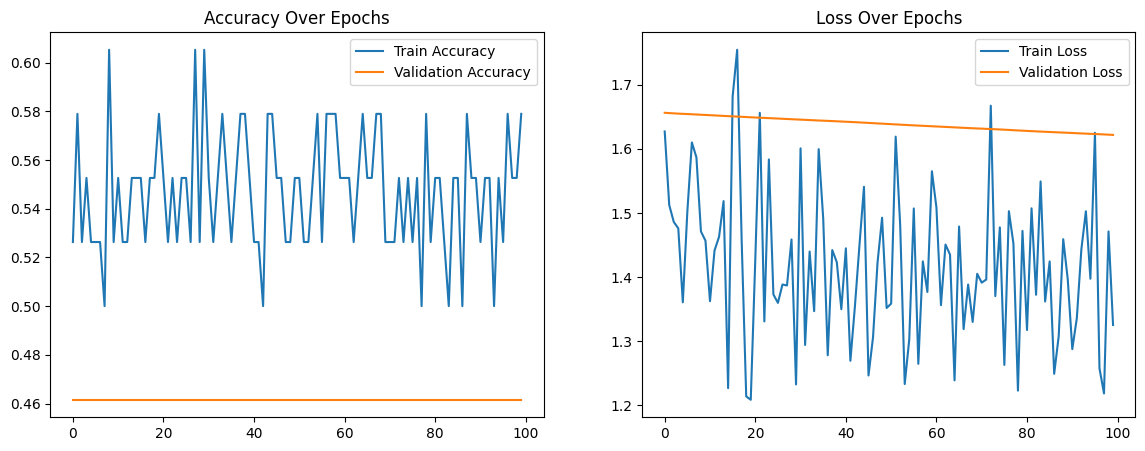

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

final_model = load_model('/content/drive/MyDrive/lstmf_model.h5')

# ===== Predict =====
y_pred_probs = final_model.predict(X_unknown)
y_pred = (y_pred_probs > 0.86).astype('int32').flatten()

# ===== Display Results =====
print("\nResults:")
for file, true_label, pred_label in zip(unknown_files, y_true, y_pred):
    print(f"{os.path.basename(file)} --> True: {true_label} | Predicted: {pred_label}")

# ===== (Optional) Calculate overall accuracy =====
from sklearn.metrics import accuracy_score, classification_report

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
# Accuracy and Loss plots
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.show()
plot_history(history)

In [1]:
print(f"Unknown dataset shape: {X_unknown.shape}")
print(f"True labels shape: {y_true.shape}")

NameError: name 'X_unknown' is not defined

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 782ms/step

Results:
AH_473R_E4947FD3-23C1-44F1-BCE4-DC59D8269FDE.wav --> True: 0 | Predicted: 1
AH_420J_07C96C2C-6E96-4A2F-BEC9-5CB71DB309B6.wav --> True: 0 | Predicted: 1
AH_678A_2E7AFA48-34C1-4DAD-A73C-95F7ABF6B138.wav --> True: 0 | Predicted: 1
AH_264Z_593C20CD-0A54-4177-B031-26EE147080A3.wav --> True: 0 | Predicted: 0
AH_444B_E1586F09-1BF5-408D-A55E-96D9E8B76A43.wav --> True: 0 | Predicted: 1
AH_777G_4C8ACC89-7FE2-4174-AE3A-B21B39A0C869.wav --> True: 0 | Predicted: 0
AH_333L_6C551A6E-CC47-410E-AA49-2DC0A86E6489.wav --> True: 0 | Predicted: 0
AH_789Y_20CB672C-5F66-425E-8707-BE5B7FF807E2.wav --> True: 0 | Predicted: 1
AH_469Z_5BB05B2C-39C4-434D-9445-244E7580F840.wav --> True: 0 | Predicted: 1
AH_753G_073DCC32-4397-4719-A019-DDD41F30F5F1.wav --> True: 0 | Predicted: 1
AH_888A_7F1444B0-B12C-4B55-AF2A-463395DCAF3C.wav --> True: 0 | Predicted: 0
AH_528T_6A746E6E-FB60-4363-842F-A7368A1E5B2C.wav --> True: 0 | Predicted: 0
AH_667J_605FB4D5-E0DB-4B9B-8F58-784561C

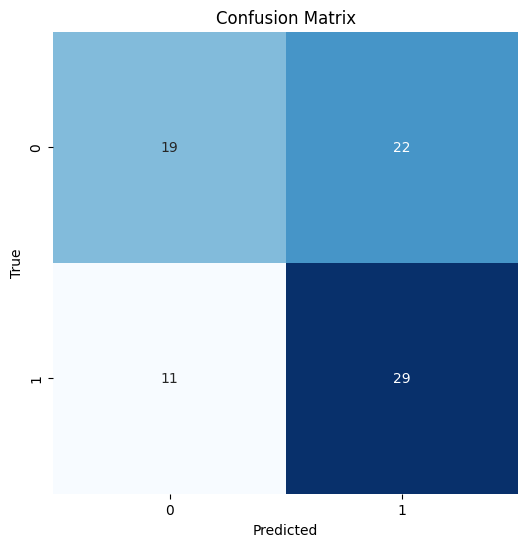


Accuracy: 0.5925925925925926

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.46      0.54        41
           1       0.57      0.72      0.64        40

    accuracy                           0.59        81
   macro avg       0.60      0.59      0.59        81
weighted avg       0.60      0.59      0.59        81



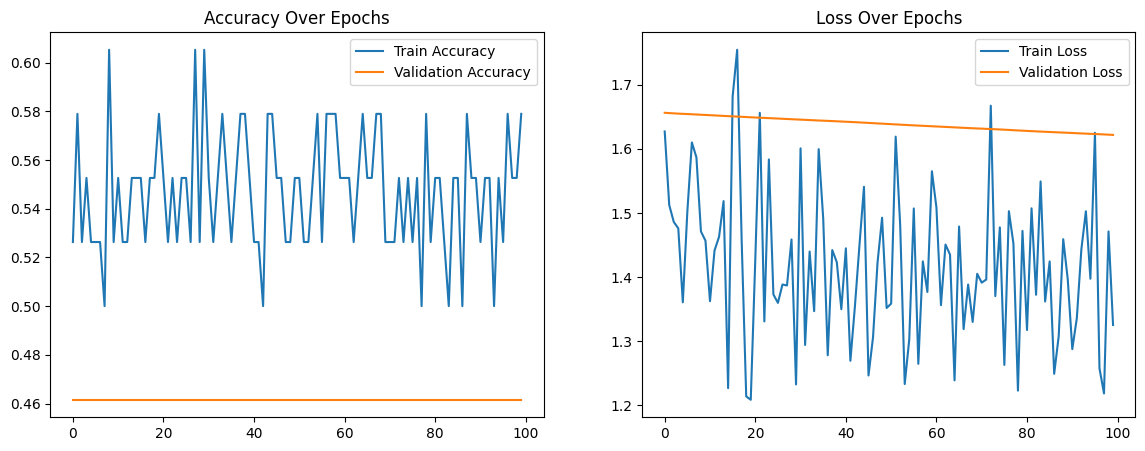

In [8]:
from tensorflow.keras.layers import Layer
# ===== Load your trained model =====
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")

        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1],),  # important: (timesteps,)
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W)  # (batch_size, time_steps, 1)
        e = tf.squeeze(e, axis=-1)            # (batch_size, time_steps)
        e = tf.keras.backend.tanh(e + self.b) # (batch_size, time_steps)

        a = tf.keras.backend.softmax(e)       # (batch_size, time_steps)
        a = tf.expand_dims(a, axis=-1)         # (batch_size, time_steps, 1)

        output = x * a                         # broadcasting
        return tf.keras.backend.sum(output, axis=1)



# If you already have 'final_model', skip loading
final_model = load_model('/content/drive/MyDrive/final_audio_model.h5', custom_objects={'Attention': Attention})

# ===== Predict =====
y_pred_probs = final_model.predict(X_unknown)
y_pred = (y_pred_probs > 0.93).astype('int32').flatten()

# ===== Display Results =====
print("\nResults:")
for file, true_label, pred_label in zip(unknown_files, y_true, y_pred):
    print(f"{os.path.basename(file)} --> True: {true_label} | Predicted: {pred_label}")

# ===== (Optional) Calculate overall accuracy =====
from sklearn.metrics import accuracy_score, classification_report

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
# Accuracy and Loss plots
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.show()

plot_history(history)

In [9]:
y_pred_prob = final_model.predict(X_unknown)

import numpy as np
from sklearn.metrics import accuracy_score

best_thresh = 0.5
best_acc = 0

# Try thresholds from 0.1 to 0.9
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred_class = (y_pred_prob >= thresh).astype("int32")
    acc = accuracy_score(y_true, y_pred_class)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f}")
print(f"Best accuracy: {best_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Best threshold: 0.84
Best accuracy: 0.5802


In [ ]:
# ------------------------ TESTING ------------------------

y_pred = (final_model.predict(X_test) > 0.5).astype("int32")



# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------ PLOTS ------------------------

# Accuracy and Loss plots
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.show()

plot_history(history)